In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

# Ridge Regression and how it fits in
OLS works my minimizing the squared sum of the distance between the error and the predicted value, which is to say that it tries to minimizes the error in the training set. Ridge and Lasso regressions are ways we can optimize the variance explained by the test set

**Ridge regression** minimizes this cost function:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$

Of note is this part of the function which differs ridge from regular OLS:

$$\lambda\sum_{j=1}^p\beta_j^2 $$

This new part imposes a penalty for large coefficients.  It represents the sum of the square of all model coefficients (numbered 1 through $p$), multiplied by the regularization parameter $\lambda$.  As $\lambda$ gets larger, the penalty for coefficient size also gets larger, and the solution that minimizes the cost function will by necessity have smaller coefficient estimates.  Regularization based on the sum of the squared weights is also called "**L2 regularization**".

The core principle behind ridge is that as models get more complex and feature multicollinearity becomes an issue, the coefficients prdicted by OLS get larger, indicating that the model is overfitting too much variance from the sample. Ridge is essentially a model variance minimizer.

## Default OLS w all features and then multicolinear features for comparison

In [2]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.5738784962717032

R-squared complex model:
0.5739734452083751

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.866]
 [-0.001 553434.485]]


In [3]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.5630697922503316

R-squared complex model:
0.5630239527344743


In [4]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613441

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


In [5]:
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.5631088763076704
0.5631804323930691


[-2.18345205e-03 -7.57156891e-01  4.77049992e-02 -3.66908529e-03
  9.52109450e-03 -3.78154074e-03 -4.47224221e-03  4.83414403e-04
 -4.79227770e-06  1.00000000e+01]
    default   student   balance  balance_student  balance_default  \
1 -0.004278 -0.758735  0.191749        -0.002308         0.011487   
2 -0.003228 -0.758358  0.115052        -0.002949         0.010465   
3 -0.002750 -0.758007  0.082093        -0.003258         0.010015   
4 -0.002464 -0.757664  0.063760        -0.003457         0.009758   
5 -0.002264 -0.757325  0.052085        -0.003606         0.009587   

   student_default  balance_sqrt  balance2  balance3  lambda  
1        -0.004209     -0.017950  0.001952 -0.000019     1.0  
2        -0.004002     -0.010782  0.001169 -0.000012     3.0  
3        -0.003904     -0.007695  0.000833 -0.000008     5.0  
4        -0.003844     -0.005977  0.000646 -0.000006     7.0  
5        -0.003800     -0.004883  0.000528 -0.000005     9.0  


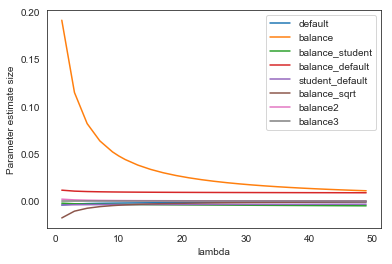

In [6]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])
print(estimates)
# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)
print(estimates_df.head())

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

# How lasso regression works and fits in with Ridge
Ridge regression seeks to shrink parameter coefficient estimates, but they never actually reach 0. Lasso regression, or least absolute shrnage and selecton operator is a model mechanic that tries to get parameter estimates to 0, effectively dropping them from the model. Very useful for datasets with hundreds, thousands, or 100,000+ features and you want to optimize processor time or even make the model much simpler and easier to interpret. 

The cost function to minimize for lasso is _very similar_ to the cost function minimized for ridge. 
$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

Instead of penalizing based on sum of squared coefficients like ridge, lasso penalizes by the sum of the _absolute_ values of the coefficients. This makes it so that regularization penalty doesn't increase as sqiftly with soefficient size. Regularization based on absolute weights is called **L1 Regularization**

If you were to graph the derivative of the result with respect to each parameter, these values set up a gradient and has a hole because the derivatives will not equal 0. So instead of a gradient descent algorithm (the one where you keep going down the gradient until you reach the bottom, but it won't work because if the model encounters the hole, it won't know what to do and terminate) we will use a coordinate descent algorithm. Basically, the algorithem will look at all features, either by comparing or removing them. If a feature is set to 0 or removed, check the correlation of the model with all features except the excluded one. If the correlation is close to 0, then that feature is set to 0 and is essentially removed. Keep this cycle going until the difference between correlation results for each subsequent cycle is less than some predefined number, such as .0001 which is the default in sklearn.

To break this down even simpler, lasso excludes one feature at a time and sees how well the model reproduces the data. If the model fits good enough (determined by lambda), then the feature is dropped and the rest of the features are tunes using a transformation based on lambda

## Setting up a lasso regression

In [7]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [8]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35, tol=.01)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
l_origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(l_origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.4436637769002981

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89396242e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -3.57527324e-04
 -1.77248367e-07  3.75350908e+00]


In [9]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380811152422615


## Comparing R2 of lasso vs ridge

In [35]:
R2 = []
#Run the model for many alphas.
for lambd in range(1, 50, 2):
    lassoregrBig = linear_model.Lasso(alpha=lambd)
    lassoregrBig.fit(X_train2, Y_train)
    ridgeBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeBig.fit(X_train2, Y_train)
    R2.append([ridgeBig.score(X_train2, Y_train), lassoregrBig.score(X_train2, Y_train), lambd])
#Plot for ridge regression R2
df_r2 = pd.DataFrame(R2, columns=['Ridge R2', 'Lasso R2', 'Lambda'])
plt.plot(df_r2['Lambda'], df_r2['Ridge R2'])
plt.xlabel('lambda')
plt.ylabel('R-squared')
plt.title("Lasso Regression R^2 for Varying Lambda")
plt.show()

#plot for ridge
plt.plot(df_r2['Lambda'], df_r2['Lasso R2'])
plt.xlabel('lambda')
plt.ylabel('R-squared')
plt.title("Lasso Regression R^2 for Varying Lambda")
plt.show()